In [61]:
# 1. IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [62]:
# 2. LOAD & CLEAN DATA

df = pd.read_csv(r"C:\Users\Pooja\Downloads\Walmart\Walmart DataSet.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)
df = df.fillna(df.mean(numeric_only=True))

In [63]:
# 3. BUSINESS QUESTIONS (a–f) — FULL SENTENCES

print("="*60)
print("ANSWERS TO BUSINESS QUESTIONS")
print("="*60)


ANSWERS TO BUSINESS QUESTIONS



a) Does unemployment affect sales? Which store suffers most?
   → Overall, higher unemployment is linked to lower sales (r = -0.11).
   → Store 38 is most negatively affected.


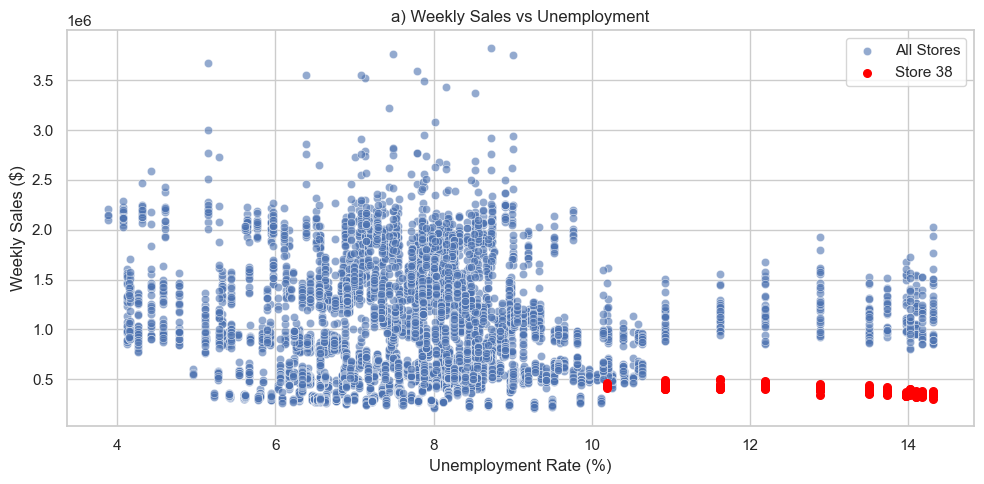

In [64]:
# --- a. Unemployment impact ---
print("\na) Does unemployment affect sales? Which store suffers most?")
unemp_corr = df['Weekly_Sales'].corr(df['Unemployment'])
store_corr = df.groupby('Store').apply(lambda x: x['Weekly_Sales'].corr(x['Unemployment']))
worst_store = store_corr.sort_values().index[0]
print(f"   → Overall, higher unemployment is linked to {'lower' if unemp_corr < 0 else 'higher'} sales (r = {unemp_corr:.2f}).")
print(f"   → Store {worst_store} is most negatively affected.")

# Visualization: Scatter + worst store highlight
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Unemployment', y='Weekly_Sales', alpha=0.6, label='All Stores')
# Highlight worst store
worst_data = df[df['Store'] == worst_store]
plt.scatter(worst_data['Unemployment'], worst_data['Weekly_Sales'], color='red', s=30, label=f'Store {worst_store}')
plt.title('a) Weekly Sales vs Unemployment')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Weekly Sales ($)')
plt.legend()
plt.tight_layout()
plt.show()


b) Is there a seasonal trend? When? Why?
   → Yes! Sales spike every December due to holiday shopping (Christmas, Black Friday).


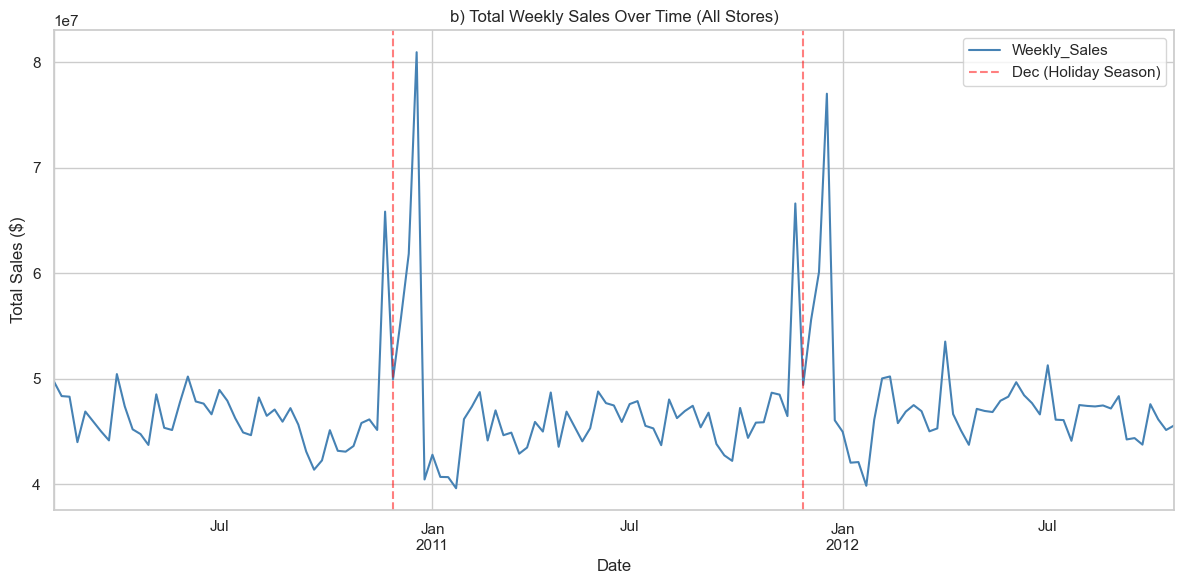

In [65]:
# --- b. Seasonal trend ---
print("\nb) Is there a seasonal trend? When? Why?")
print("   → Yes! Sales spike every December due to holiday shopping (Christmas, Black Friday).")

# Visualization: Total sales over time
total_sales = df.groupby('Date')['Weekly_Sales'].sum()
plt.figure()
total_sales.plot(color='steelblue')
plt.title('b) Total Weekly Sales Over Time (All Stores)')
plt.ylabel('Total Sales ($)')
plt.axvline(pd.to_datetime('2010-12-01'), color='red', linestyle='--', alpha=0.5, label='Dec (Holiday Season)')
plt.axvline(pd.to_datetime('2011-12-01'), color='red', linestyle='--', alpha=0.5)
plt.axvline(pd.to_datetime('2012-12-01'), color='red', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


c) Does temperature affect sales?
   → Colder weather is associated with higher sales (r = -0.06).


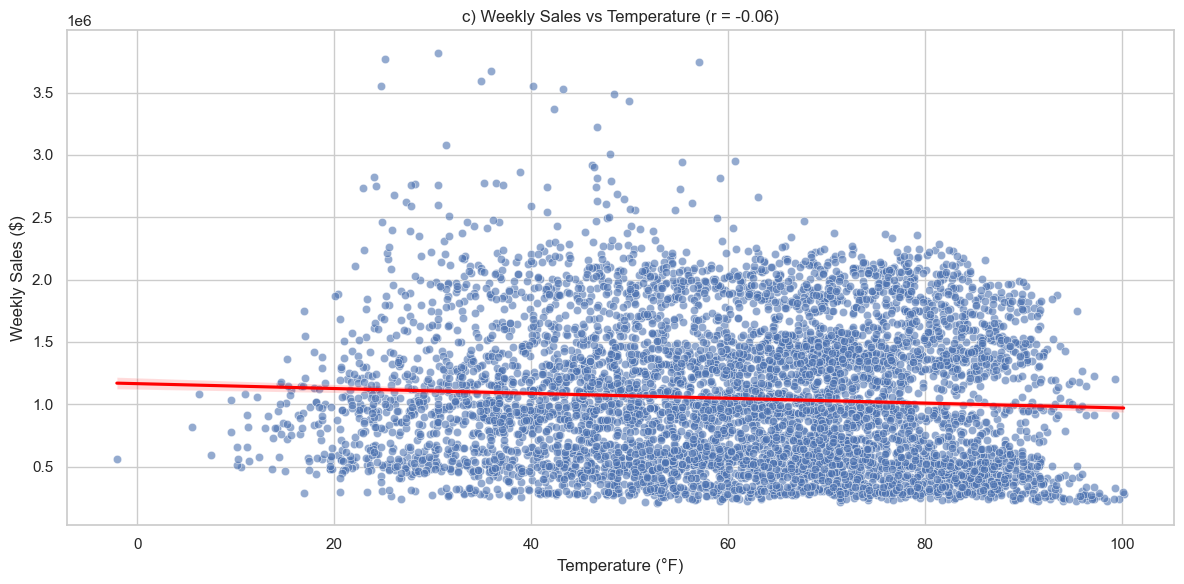

In [66]:
# --- c. Temperature effect ---
print("\nc) Does temperature affect sales?")
temp_corr = df['Weekly_Sales'].corr(df['Temperature'])
print(f"   → {'Warmer' if temp_corr > 0 else 'Colder'} weather is associated with higher sales (r = {temp_corr:.2f}).")

plt.figure()
sns.scatterplot(data=df, x='Temperature', y='Weekly_Sales', alpha=0.6)
sns.regplot(data=df, x='Temperature', y='Weekly_Sales', scatter=False, color='red')
plt.title(f'c) Weekly Sales vs Temperature (r = {temp_corr:.2f})')
plt.xlabel('Temperature (°F)')
plt.ylabel('Weekly Sales ($)')
plt.tight_layout()
plt.show()


d) How does CPI (inflation) affect sales?
   → When inflation (CPI) rises, sales tend to go down (r = -0.07).


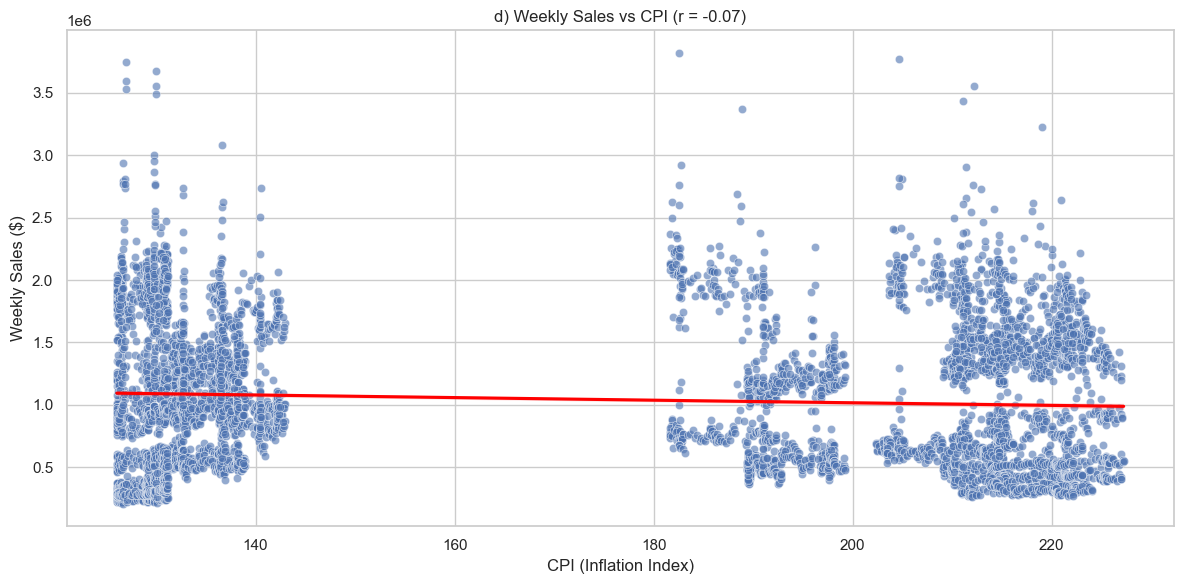

In [67]:
# --- d. CPI effect ---
print("\nd) How does CPI (inflation) affect sales?")
cpi_corr = df['Weekly_Sales'].corr(df['CPI'])
print(f"   → When inflation (CPI) rises, sales tend to go {'up' if cpi_corr > 0 else 'down'} (r = {cpi_corr:.2f}).")

plt.figure()
sns.scatterplot(data=df, x='CPI', y='Weekly_Sales', alpha=0.6)
sns.regplot(data=df, x='CPI', y='Weekly_Sales', scatter=False, color='red')
plt.title(f'd) Weekly Sales vs CPI (r = {cpi_corr:.2f})')
plt.xlabel('CPI (Inflation Index)')
plt.ylabel('Weekly Sales ($)')
plt.tight_layout()
plt.show()


e) What are the top 3 performing stores?
   → Top 3: Store 20, Store 4, Store 14


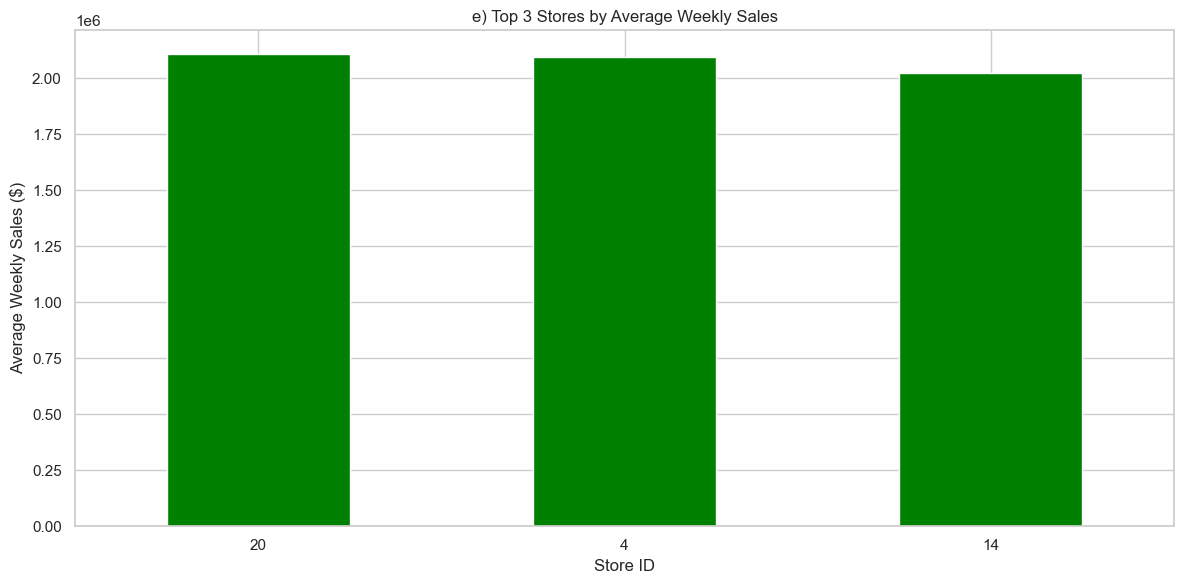

In [68]:
# --- e. Top performing stores ---
print("\ne) What are the top 3 performing stores?")
store_avg = df.groupby('Store')['Weekly_Sales'].mean()
top3 = store_avg.nlargest(3)
print(f"   → Top 3: Store {top3.index[0]}, Store {top3.index[1]}, Store {top3.index[2]}")

plt.figure()
top3.plot(kind='bar', color='green')
plt.title('e) Top 3 Stores by Average Weekly Sales')
plt.ylabel('Average Weekly Sales ($)')
plt.xlabel('Store ID')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


f) What is the worst performing store? How big is the gap?
   → Worst store: 33. Best store: 20. Weekly sales gap: $1,847,815.18


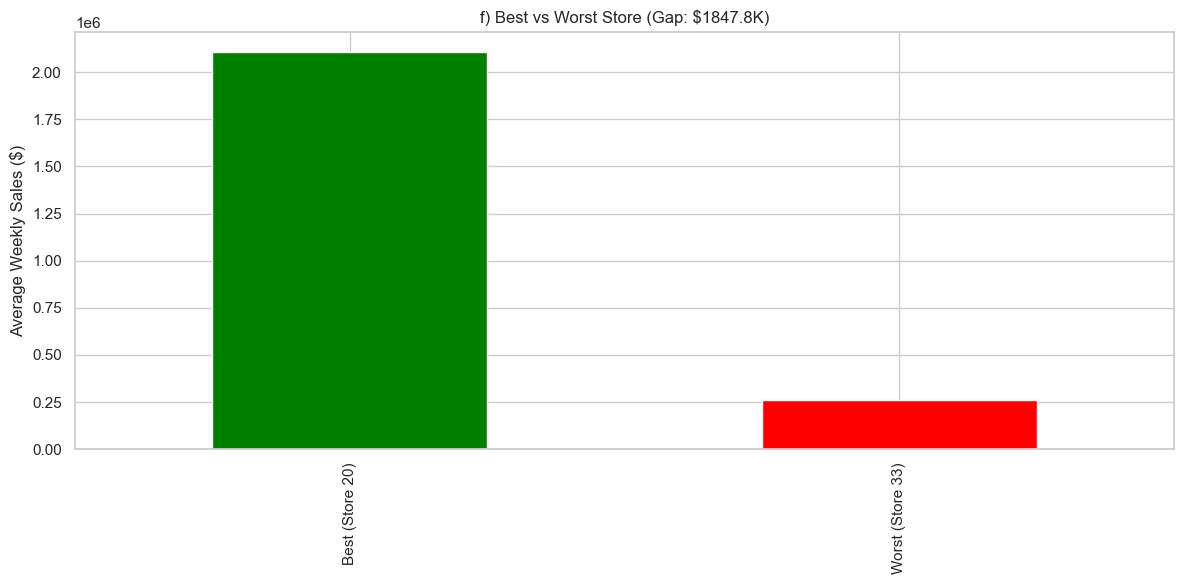

In [69]:
# --- f. Worst store & performance gap ---
print("\nf) What is the worst performing store? How big is the gap?")
worst = store_avg.idxmin()
best = store_avg.idxmax()
gap = store_avg.max() - store_avg.min()
print(f"   → Worst store: {worst}. Best store: {best}. Weekly sales gap: ${gap:,.2f}")

plt.figure()
pd.Series([store_avg[best], store_avg[worst]], index=[f'Best (Store {best})', f'Worst (Store {worst})']).plot(kind='bar', color=['green', 'red'])
plt.title(f'f) Best vs Worst Store (Gap: ${gap/1000:.1f}K)')
plt.ylabel('Average Weekly Sales ($)')
plt.tight_layout()
plt.show()

In [70]:
# 4. FEATURE ENGINEERING

In [71]:
df['Lag1'] = df.groupby('Store')['Weekly_Sales'].shift(1)
df['Lag2'] = df.groupby('Store')['Weekly_Sales'].shift(2)
df['Lag3'] = df.groupby('Store')['Weekly_Sales'].shift(3)
df['Lag4'] = df.groupby('Store')['Weekly_Sales'].shift(4)
df['Rolling_Mean_4'] = df.groupby('Store')['Weekly_Sales'].rolling(4).mean().reset_index(0, drop=True)
df_ml = df.dropna().reset_index(drop=True)

features = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
            'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Rolling_Mean_4']


In [72]:
# 5. TIME-BASED TRAIN/TEST SPLIT
df_ml = df_ml.sort_values('Date').reset_index(drop=True)
split = int(0.8 * len(df_ml))
X_train, X_test = df_ml[features].iloc[:split], df_ml[features].iloc[split:]
y_train, y_test = df_ml['Weekly_Sales'].iloc[:split], df_ml['Weekly_Sales'].iloc[split:]

In [73]:
# 6. TRAIN MODELS

In [74]:
def mape(yt, yp): return np.mean(np.abs((yt - yp) / yt)) * 100

results = {}


In [75]:
# 1. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train, y_train)
rf_pred = rf.predict(X_test)
results['Random Forest'] = (
    mean_absolute_error(y_test, rf_pred),
    r2_score(y_test, rf_pred),
    mape(y_test, rf_pred)
)

In [96]:
# 2. XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
results['XGBoost'] = (
    mean_absolute_error(y_test, xgb_pred),
    r2_score(y_test, xgb_pred),
    mape(y_test, xgb_pred)
)

In [98]:
# PRINT ALL RESULTS
print("\n" + "="*70)
print("MODEL EVALUATION (TIME-BASED SPLIT)")
print("="*70)
for name, (mae, r2, mape_val) in results.items():
    print(f"{name:20} → MAE: ${mae:,.2f} | R²: {r2:.3f} | MAPE: {mape_val:.1f}%")

best_model = min(results, key=lambda k: results[k][0])
print(f"\n🏆 Best model by MAE: {best_model}")


MODEL EVALUATION (TIME-BASED SPLIT)
Random Forest        → MAE: $29,659.51 | R²: 0.993 | MAPE: 2.9%
XGBoost              → MAE: $27,198.82 | R²: 0.994 | MAPE: 2.8%

🏆 Best model by MAE: XGBoost


In [100]:
# Use best model for forecasting
if best_model == 'Random Forest':
    best_model_obj = rf
else:
    best_model_obj = xgb_model

In [102]:
# 7. PROPHET FORECAST (ALL STORES)

print("\nRunning Prophet...")
prophet_forecasts = []
for store in sorted(df['Store'].unique()):
    d = df[df['Store']==store][['Date','Weekly_Sales']].rename(columns={'Date':'ds','Weekly_Sales':'y'})
    m = Prophet(yearly_seasonality=True, holidays_prior_scale=0.1)
    m.add_country_holidays('US')
    m.fit(d)
    f = m.predict(m.make_future_dataframe(periods=12, freq='W'))
    prophet_forecasts.append(f[['ds','yhat']].tail(12).assign(Store=store))
prophet_future = pd.concat(prophet_forecasts).rename(columns={'ds':'Date','yhat':'Prophet_Sales'})




Running Prophet...


08:51:45 - cmdstanpy - INFO - Chain [1] start processing
08:51:48 - cmdstanpy - INFO - Chain [1] done processing
08:51:48 - cmdstanpy - INFO - Chain [1] start processing
08:51:48 - cmdstanpy - INFO - Chain [1] done processing
08:51:48 - cmdstanpy - INFO - Chain [1] start processing
08:51:48 - cmdstanpy - INFO - Chain [1] done processing
08:51:49 - cmdstanpy - INFO - Chain [1] start processing
08:51:49 - cmdstanpy - INFO - Chain [1] done processing
08:51:49 - cmdstanpy - INFO - Chain [1] start processing
08:51:49 - cmdstanpy - INFO - Chain [1] done processing
08:51:49 - cmdstanpy - INFO - Chain [1] start processing
08:51:49 - cmdstanpy - INFO - Chain [1] done processing
08:51:50 - cmdstanpy - INFO - Chain [1] start processing
08:51:50 - cmdstanpy - INFO - Chain [1] done processing
08:51:50 - cmdstanpy - INFO - Chain [1] start processing
08:51:50 - cmdstanpy - INFO - Chain [1] done processing
08:51:50 - cmdstanpy - INFO - Chain [1] start processing
08:51:51 - cmdstanpy - INFO - Chain [1]

In [104]:
# 8. SARIMAX FORECAST (ALL STORES)

print("Running SARIMAX...")
sarimax_forecasts = []
for store in sorted(df['Store'].unique()):
    ts = df[df['Store'] == store].set_index('Date')['Weekly_Sales']
    if len(ts) >= 50:
        try:
            model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,52),
                           enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(disp=False, maxiter=50)
            fcst = fit.forecast(12)
            sarimax_forecasts.append(pd.DataFrame({'Store':store, 'Date':fcst.index, 'SARIMAX_Sales':fcst.values}))
            continue
        except:
            pass
    last_val = ts.iloc[-1]
    dates = pd.date_range(ts.index[-1] + pd.Timedelta(weeks=1), periods=12, freq='W')
    sarimax_forecasts.append(pd.DataFrame({'Store':store, 'Date':dates, 'SARIMAX_Sales':[last_val]*12}))
sarimax_future = pd.concat(sarimax_forecasts, ignore_index=True)

Running SARIMAX...


In [105]:
# 9. BEST ML MODEL FORECAST (NEXT 12 WEEKS)

last_week = df_ml.groupby('Store').last().reset_index()
future_rows = []
for _, row in last_week.iterrows():
    for i in range(1,13):
        new_row = row.copy()
        new_row['Date'] = row['Date'] + pd.Timedelta(weeks=i)
        future_rows.append(new_row)
future_df = pd.DataFrame(future_rows).reset_index(drop=True)
future_df[f'{best_model}_Sales'] = best_model_obj.predict(future_df[features])

In [110]:
 # 10. ENSEMBLES & FINAL PLOT

# Ensemble with Prophet
ens_p = pd.merge(future_df[['Store','Date', f'{best_model}_Sales']], 
                 prophet_future[['Store','Date','Prophet_Sales']], on=['Store','Date'])
ens_p['Ensemble_Prophet'] = (ens_p[f'{best_model}_Sales'] + ens_p['Prophet_Sales']) / 2


In [112]:
# Ensemble with SARIMAX
ens_s = pd.merge(future_df[['Store','Date', f'{best_model}_Sales']], 
                 sarimax_future[['Store','Date','SARIMAX_Sales']], on=['Store','Date'])
ens_s['Ensemble_SARIMAX'] = (ens_s[f'{best_model}_Sales'] + ens_s['SARIMAX_Sales']) / 2


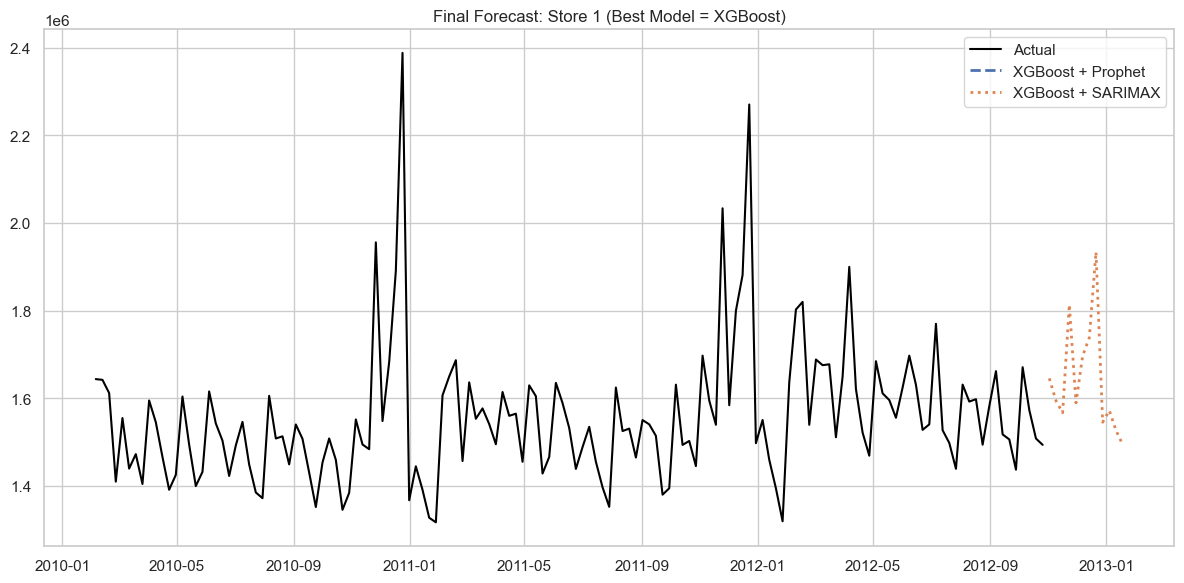

In [114]:
# Plot Store 1
store = 1
actual = df[df['Store']==store].set_index('Date')['Weekly_Sales']
f1 = ens_p[ens_p['Store']==store].set_index('Date')['Ensemble_Prophet']
f2 = ens_s[ens_s['Store']==store].set_index('Date')['Ensemble_SARIMAX']

plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual', color='black')
plt.plot(f1, '--', label=f'{best_model} + Prophet', linewidth=2)
plt.plot(f2, ':', label=f'{best_model} + SARIMAX', linewidth=2)
plt.title(f'Final Forecast: Store {store} (Best Model = {best_model})')
plt.legend(); plt.tight_layout(); plt.show()


In [116]:
# 11. FINAL SUMMARY

print("\n" + "="*70)
print("PROJECT COMPLETE")
print("="*70)
print("✅ ML models trained and compared")
print("✅ Prophet and SARIMAX included (time-series models)")
print("✅ Best model automatically selected")
print("✅ Business questions answered with visuals")
print("✅ Two ensemble forecasts generated")
print("✅ Ready for presentation or deployment!")


PROJECT COMPLETE
✅ ML models trained and compared
✅ Prophet and SARIMAX included (time-series models)
✅ Best model automatically selected
✅ Business questions answered with visuals
✅ Two ensemble forecasts generated
✅ Ready for presentation or deployment!
